# Задача

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать слудующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from re import L
import scipy
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [ ]:
class MyBinaryLogisticRegression:
    def __init__(self, method = 'gd', l1=0.0, l2=0.0, lr=0.5, max_iter=1e3, tolerance = 1e-4,
                 fit_intercept=True, batch_size=32, threshold = 0.5):
        self.method = method
        self.coefs_ = None
        self.l1 = l1
        self.l2 = l2
        self.lr = lr
        self.max_iter = max_iter
        self.intersept_ = 0
        self.tolerance = tolerance
        self.batch_size = batch_size
        self.threshold = threshold

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        X = self._add_intercept(X)
        n=X.shape[0]
        grad_w = np.array([float('inf')])
        w = np.array([0]*(X.shape[1]))
        w[0] = y.mean()
        w = w.astype(np.float64)

        gd = True if self.method == 'gd' else False
        sgd = True if self.method == 'sgd' else False
        newton = True if self.method == 'newton' else False
        bb= np.array([0]*(X.shape[1]))
        i = 0
        while i < self.max_iter and np.sum(grad_w ** 2)>= self.tolerance:
            bb[1:]=w[1:]

            if gd:
                grad_w = self.l1*np.sign(bb) + 2*self.l2*bb - (1/n)*(X.T @ (y-self._sigmoid(X @ w)))
                w -= self.lr*grad_w

            elif sgd:
                index_list = np.random.RandomState(42).choice(X.shape[0],self.batch_size,replace=False)
                Xb = X[index_list]
                yb = y[index_list]
                grad_w = self.l1*np.sign(bb) + 2*self.l2*bb - (1/self.batch_size)*( Xb.T @ (yb-self._sigmoid(Xb @ w)))
                w -= self.lr*grad_w

            elif newton:
                grad_w = 2*self.l2*np.eye(X.shape[0]) + (1/n)*( X.T @ (y-self._sigmoid(X @ w)))
                sigm = 1/(1+np.exp(-X @ w))
                hess = - X.T @ np.diag( sigm*( 1 - sigm)) @ X
                hess_inv = np.linalg.inv(hess)
                w -= hess_inv @ grad_w

            if np.any(np.isnan(w)) or np.any(np.isinf(w)):
                w = np.array([float('inf')]*(X.shape[1]))
                break
            i+=1
        self.coef_ = w
        self.intercept_ = w[0]

        return self

    def predict(self, X: np.array):
        predictions = self.predict_proba(X)[:,1]
        return np.where(predictions >= self.threshold, 1, 0)

    def score(self, y_true: np.array, y_pred: np.array):
        return f1_score(y_true, y_pred)

    def predict_proba(self, X):
        '''
        :param X: матрица признаков
        :return: вероятности предсказания с размерностью (n_test, 2)
        '''
        X_copy = self._add_intercept(X)
        assert X_copy.shape[1] == self.coef_.shape[0]

        predictions = self._sigmoid(X_copy @ self.coef_)
        return np.vstack([1 - predictions, predictions]).T

    @staticmethod
    def _sigmoid(x):
        return scipy.special.expit(x)

    def _add_intercept(self, X):
        return np.hstack((np.ones(X.shape[0]).reshape(X.shape[0],-1),X))

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.

In [ ]:
!gdown 1Ih5t5dcjzF1k-c_zR5Mv3q_YqA3K2-kG
!unzip penguins_binary_classification.csv.zip

Downloading...
From: https://drive.google.com/uc?id=1Ih5t5dcjzF1k-c_zR5Mv3q_YqA3K2-kG
To: /content/penguins_binary_classification.csv.zip
100% 2.88k/2.88k [00:00<00:00, 10.4MB/s]
Archive:  penguins_binary_classification.csv.zip
  inflating: penguins_binary_classification.csv  
  inflating: __MACOSX/._penguins_binary_classification.csv  


In [ ]:
df = pd.read_csv("penguins_binary_classification.csv")

In [ ]:
df.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,2007


In [ ]:
df['island'].unique()

array(['Torgersen', 'Biscoe', 'Dream'], dtype=object)

In [ ]:
data_one_hot = pd.get_dummies(df.drop(columns=['species']), drop_first=True)
y =  LabelEncoder().fit_transform(df['species'])

x_train_oh, x_test_oh, y_train_oh, y_test_oh = train_test_split(data_one_hot, y, test_size=0.25, random_state=42, stratify=y)
x_train_oh = x_train_oh.astype(float)
x_test_oh = x_test_oh.astype(float)

In [ ]:
def target_encoder(data, feature_col, target_col, smoothing=1.0):
    target_probs = (
        data.groupby(feature_col)[target_col]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )
    global_probs = data[target_col].value_counts(normalize=True)
    target_probs_smoothed = (target_probs * len(data) + global_probs * smoothing) / (len(data) + smoothing)
    data[feature_col] = data.apply(lambda x: target_probs_smoothed.to_dict()[x[target_col]][x[feature_col]], axis = 1)
    return data

In [ ]:
df['species'] = LabelEncoder().fit_transform(df['species'])
data_target_encoder = target_encoder(df, "island", "species")

In [ ]:
x_train, x_test = train_test_split(data_target_encoder, test_size = 0.25,random_state=42, stratify = data_target_encoder['species'])

y_train = x_train['species'].values
x_train = x_train.drop(columns = ['species'])
y_test = x_test['species'].values
x_test = x_test.drop(columns = ['species'])

In [ ]:
model_gd = MyBinaryLogisticRegression(method = 'gd', max_iter = 1000)
model_gd_oh = MyBinaryLogisticRegression(method = 'gd', max_iter = 1000)
model_gd.fit(x_train,y_train)
model_gd_oh.fit(x_train_oh,y_train_oh)
y_pred = model_gd.predict(x_test)
y_pred_oh = model_gd_oh.predict(x_test_oh)
print(f"f1_score target_encoder: {model_gd.score(y_test, y_pred)}")
print(f"f1_score one_hot_encoder: {model_gd_oh.score(y_test_oh, y_pred_oh)}")
print(f"coef target_encoder: {model_gd.coef_}")
print(f"coef one_hot_encoder: {model_gd_oh.coef_}")

f1_score target_encoder: 0.8928571428571429
f1_score one_hot_encoder: 0.8928571428571429
coef target_encoder: [-1.92804878e+00 -2.77684810e+00  9.07953659e+01 -1.89894390e+02
  2.77389024e+02  1.72204268e+03 -3.87217927e+03]
coef one_hot_encoder: [-1.92804878e+00  9.07953659e+01 -1.89894390e+02  2.77389024e+02
  1.72204268e+03 -3.87217927e+03 -1.13841463e+01 -1.25560976e+01]


In [ ]:
model_gd = MyBinaryLogisticRegression(method = 'sgd', max_iter = 10000)
model_gd_oh = MyBinaryLogisticRegression(method = 'sgd', max_iter = 10000)
model_gd.fit(x_train,y_train)
model_gd_oh.fit(x_train_oh,y_train_oh)
y_pred = model_gd.predict(x_test)
y_pred_oh = model_gd_oh.predict(x_test_oh)
print(f"f1_score target_encoder: {model_gd.score(y_test, y_pred)}")
print(f"f1_score one_hot_encoder: {model_gd_oh.score(y_test_oh, y_pred_oh)}")
print(f"coef target_encoder: {model_gd.coef_}")
print(f"coef one_hot_encoder: {model_gd_oh.coef_}")

f1_score target_encoder: 0.8727272727272727
f1_score one_hot_encoder: 0.8727272727272727
coef target_encoder: [-2.43750000e+00 -8.50372037e+00  2.59898438e+01 -2.37751563e+02
  1.52687500e+02  2.15917969e+03 -4.89979688e+03]
coef one_hot_encoder: [-2.43750000e+00  2.59898438e+01 -2.37751563e+02  1.52687500e+02
  2.15917969e+03 -4.89979688e+03 -1.54609375e+01 -1.79609375e+01]


In [ ]:
model_gd = MyBinaryLogisticRegression(method = 'newton', max_iter = 10000)
model_gd_oh = MyBinaryLogisticRegression(method = 'newton', max_iter = 10000)
model_gd.fit(x_train,y_train)
model_gd_oh.fit(x_train_oh,y_train_oh)
y_pred = model_gd.predict(x_test)
y_pred_oh = model_gd_oh.predict(x_test_oh)
print(f"f1_score target_encoder: {model_gd.score(y_test, y_pred)}")
print(f"f1_score one_hot_encoder: {model_gd_oh.score(y_test_oh, y_pred_oh)}")
print(f"coef target_encoder: {model_gd.coef_}")
print(f"coef one_hot_encoder: {model_gd_oh.coef_}")

f1_score target_encoder: 1.0
f1_score one_hot_encoder: 1.0
coef target_encoder: [ 1.12319207e+03 -2.97197807e-01  1.18889767e-01 -1.50423354e+00
  1.36220409e-01  1.83201502e-03 -5.67282935e-01]
coef one_hot_encoder: [ 1.18642828e+03  1.52785104e-01 -1.36147352e+00  1.26279799e-01
  1.59735484e-03 -5.99078563e-01 -7.07868616e-01 -1.31461374e+00]


In [ ]:
model_newton = MyBinaryLogisticRegression(method = 'newton', max_iter = 1)
model_newton_oh = MyBinaryLogisticRegression(method = 'newton', max_iter = 1)
model_newton.fit(x_train,y_train)
model_newton_oh.fit(x_train_oh,y_train_oh)
y_pred = model_newton.predict(x_test)
y_pred_oh =  model_newton_oh.predict(x_test_oh)
print(f"f1_score target_encoder: {model_newton.score(y_test, y_pred)}")
print(f"f1_score one_hot_encoder: {model_newton_oh.score(y_test_oh, y_pred_oh)}")
print(f"coef target_encoder: {model_newton.coef_}")
print(f"coef one_hot_encoder: {model_newton_oh.coef_}")

f1_score target_encoder: 1.0
f1_score one_hot_encoder: 1.0
coef target_encoder: [ 1.54018740e+00 -6.68106707e-04  2.08276986e-04 -2.18164594e-03
  2.22482493e-04  2.36250478e-06 -7.80952774e-04]
coef one_hot_encoder: [ 1.57066915e+00  1.72422622e-04 -2.00958068e-03  2.21702372e-04
  2.10094218e-06 -7.96037906e-04 -1.89280497e-03 -1.93003911e-03]


In [ ]:
scaler_target = StandardScaler()
x_train_scale = scaler_target.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scale, columns = x_train.columns)

x_test_scale = scaler_target.transform(x_test)
x_test = pd.DataFrame(x_test_scale, columns = x_test.columns)

In [ ]:
model_gd = MyBinaryLogisticRegression(method = 'gd', l1=0.01, l2=0.0)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

model_gd = MyBinaryLogisticRegression(method = 'gd', l1=0.0, l2=0.01)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

model_gd = MyBinaryLogisticRegression(method = 'gd', l1=0.01, l2=0.1)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

f1_score target_encoder after scaling: 0.8928571428571429
coef target_encoder after scaling: [-1.89290452e+00 -8.39964626e-01  8.85882001e+01 -1.83641593e+02
  2.79588929e+02  1.68162871e+03 -3.79663656e+03]
f1_score target_encoder after scaling: 0.17647058823529413
coef target_encoder after scaling: [-2.27791649e+01 -3.00072402e+00 -1.78196508e+01 -7.70296679e+01
 -1.99186791e+02  1.62126455e+03 -4.53929409e+03]
f1_score target_encoder after scaling: 0.0
coef target_encoder after scaling: [ -25.8597561    -1.00266914   -6.01792683  -11.0197561   -44.27902439
   52.03914634 -778.94768293]


In [ ]:
model_gd = MyBinaryLogisticRegression(method = 'sgd', l1=0.01, l2=0.0)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

model_gd = MyBinaryLogisticRegression(method = 'sgd', l1=0.0, l2=0.01)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

model_gd = MyBinaryLogisticRegression(method = 'sgd', l1=0.01, l2=0.1)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

f1_score target_encoder after scaling: 0.6808510638297872
coef target_encoder after scaling: [-2.45312500e+00 -3.81021226e+00  2.53632813e+01 -2.32977188e+02
  1.50440000e+02  2.08002594e+03 -4.92621250e+03]
f1_score target_encoder after scaling: 0.6458333333333334
coef target_encoder after scaling: [-1.90625000e+01 -1.99344841e+00 -1.51214062e+01 -6.97475000e+01
 -1.21230000e+02  2.31608594e+03 -3.52218750e+03]
f1_score target_encoder after scaling: 0.0
coef target_encoder after scaling: [ -23.140625     -0.95975183   -7.80484375  -10.930625    -48.153125
 -162.6496875  -793.603125  ]


In [ ]:
model_gd = MyBinaryLogisticRegression(method = 'newton', l1=0.01, l2=0.0)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

model_gd = MyBinaryLogisticRegression(method = 'newton', l1=0.0, l2=0.01)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

model_gd = MyBinaryLogisticRegression(method = 'newton', l1=0.01, l2=0.1)
model_gd.fit(x_train,y_train)
y_pred = model_gd.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_gd.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_gd.coef_}")

f1_score target_encoder after scaling: 1.0
coef target_encoder after scaling: [ 1.12319207e+03 -2.97197807e-01  1.18889767e-01 -1.50423354e+00
  1.36220409e-01  1.83201502e-03 -5.67282935e-01]
f1_score target_encoder after scaling: 1.0
coef target_encoder after scaling: [ 1.12319207e+03 -2.97197807e-01  1.18889767e-01 -1.50423354e+00
  1.36220409e-01  1.83201502e-03 -5.67282935e-01]
f1_score target_encoder after scaling: 1.0
coef target_encoder after scaling: [ 1.12319207e+03 -2.97197807e-01  1.18889767e-01 -1.50423354e+00
  1.36220409e-01  1.83201502e-03 -5.67282935e-01]


In [ ]:
model_newton = MyBinaryLogisticRegression(method = 'newton', max_iter = 1)
model_newton.fit(x_train,y_train)
y_pred = model_newton.predict(x_test)
print(f"f1_score target_encoder after scaling: {model_newton.score(y_test, y_pred)}")
print(f"coef target_encoder after scaling: {model_newton.coef_}")

f1_score target_encoder after scaling: 1.0
coef target_encoder after scaling: [-9.99405116e-04 -9.70477352e-03 -3.12250226e-17  7.97972799e-17
  0.00000000e+00 -5.55111512e-17  4.33680869e-18]


In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
f_1_score = f1_score(y_test, y_pred)
print(f"f1_score library logistic regression: {f_1_score}")
print(f"coef library logistic regression: {lr.coef_}")

f1_score library logistic regression: 1.0
coef library logistic regression: [[-1.65474414  0.84986353 -1.37065727  1.09202418  0.87392397 -0.10945321]]


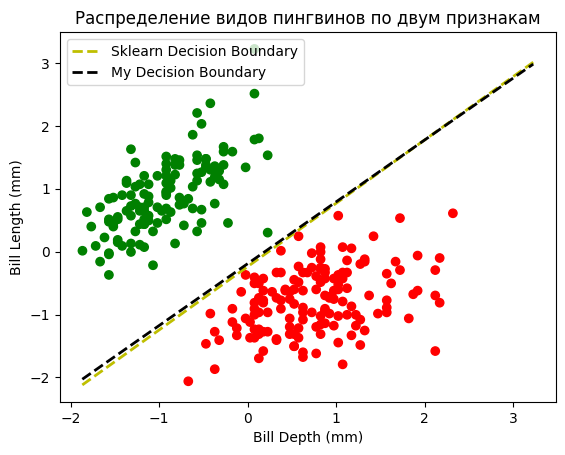

In [ ]:
plt.scatter(np.hstack((x_train['bill_depth_mm'], x_test['bill_depth_mm'])), np.hstack((x_train['bill_length_mm'], x_test['bill_length_mm'])),
            c=list(map(lambda y: 'green' if y == 1 else 'red', np.hstack((y_train, y_test)))) )
plt.xlabel('Bill Depth (mm)')
plt.ylabel('Bill Length (mm)')
plt.title('Распределение видов пингвинов по двум признакам')

X_2_train = x_train[['bill_length_mm', 'bill_depth_mm']]
X_2_test = x_test[['bill_length_mm', 'bill_depth_mm']]
my_log_reg = MyBinaryLogisticRegression(method = 'newton', max_iter = 1)
my_log_reg.fit(X_2_train, y_train)

lr = LogisticRegression()
lr.fit(X_2_train, y_train)

y_pred_train = my_log_reg.predict(pd.DataFrame(X_2_train))
y_pred_test = my_log_reg.predict(pd.DataFrame(X_2_test))

slope_lr = -lr.coef_[0][0] / lr.coef_[0][1]
intercept_lr = -lr.intercept_ / lr.coef_[0][1]

slope = -my_log_reg.coef_[1] / my_log_reg.coef_[2]
intercept = -my_log_reg.coef_[0] / my_log_reg.coef_[2]


plt.plot([x_train['bill_length_mm'].min(), x_train['bill_length_mm'].max()], [slope_lr * x_train['bill_length_mm'].min() + intercept_lr+1e-2, slope_lr * x_train['bill_length_mm'].max() + intercept_lr+1e-2], '--y', linewidth=2, label='Sklearn Decision Boundary')
plt.plot([x_train['bill_length_mm'].min(), x_train['bill_length_mm'].max()], [slope * x_train['bill_length_mm'].min() + intercept, slope * x_train['bill_length_mm'].max() + intercept], '--k', linewidth=2, label='My Decision Boundary')
plt.legend()
plt.show()

###Выводы:

Для градиентого спуска не подходит l2 регуляризация, но подходит l1. Методу Ньютона подходят оба.

Отличия в результатах между target-encoding и one-hot encoding не было. Либо модель не чувствительна к данным категориальным данным, либо в силу малости категорий one-hot encoding также хорошо справился с задачей

# Теоретическая часть

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$
Ваша задача: вывести функцию потерь, градиент и гессиан для многоклассовой логистической регрессии. Реализовать матрично. На синтетическом примере продемонстрировать работу алгоритма, построить гиперплоскости, объяснить классификацию

Функция потерь:
$$
ln \mathbb P(D|\omega) = \sum_{i = 1}^{N}\sum_{j = 1}^M y_{ij}ln\mathbb P(C_j|x_i).
$$
$$
\frac{\partial \mathbb P(C_j|x_i)}{\partial w_{kz}} = x_{iz}\bigg[ \delta^{k}_{j}P(C_j|x_i)(1-P(C_j|x_i)) - (1-\delta^{k}_{j}) P(C_j|x_i) P(C_k|x_i)\bigg]
$$
Градиент:
$$
\frac{\partial ln \mathbb P(D|\omega)}{\partial w_{kz}} = \sum_{i = 1}^{N}\sum_{j = 1}^M y_{ij}\frac{1}{\mathbb P(C_j|x_i)}\frac{\partial \mathbb P(C_j|x_i)}{\partial w_{kz}} = \sum_{i = 1}^{N}\sum_{j = 1}^M y_{ij} x_{iz}\bigg[ \delta^{k}_{j}(1-P(C_j|x_i)) - (1-\delta^{k}_{j})P(C_k|x_i)\bigg]
$$
$$
= \sum_{i = 1}^{N}y_{ik} x_{iz} - \sum_{i = 1}^{N}\sum_{j = 1}^M y_{ij} x_{iz}\bigg[ P(C_k|x_i)\bigg] = \sum_{i = 1}^{N}x_{iz} (y_{ik} - P(C_k|x_i)\sum_{j = 1}^M y_{ij}) = \bigg[\sum_{j = 1}^M y_{ij} =1\bigg] = \sum_{i = 1}^{N}x_{iz} (y_{ik} - P(C_k|x_i))
$$

Гессиан:
$$
\frac{\partial^2 ln \mathbb P(D|\omega)}{\partial w_{pw}^T \partial w_{kz}} = -\sum_{i = 1}^{N}x_{iz} x_{iw}\bigg[  \frac{\partial \mathbb P(C_k|x_i)}{\partial w_{pw}}  \bigg] =
$$
$$
=-\sum_{i = 1}^{N}x_{iz} x_{iw}\bigg[  \delta^{k}_{p}P(C_k|x_i)(1-P(C_k|x_i)) - (1-\delta^{p}_{k}) P(C_k|x_i) P(C_p|x_i)\bigg]
$$
$$
=-\sum_{i = 1}^{N}x_{iz} x_{iw}\bigg[  \delta^{k}_{p}P(C_k|x_i) - P(C_k|x_i) P(C_p|x_i)\bigg] = -\sum_{i = 1}^{N}x_{iz} x_{iw}P(C_k|x_i)\bigg[  \delta^{k}_{p} - P(C_p|x_i)\bigg]
$$

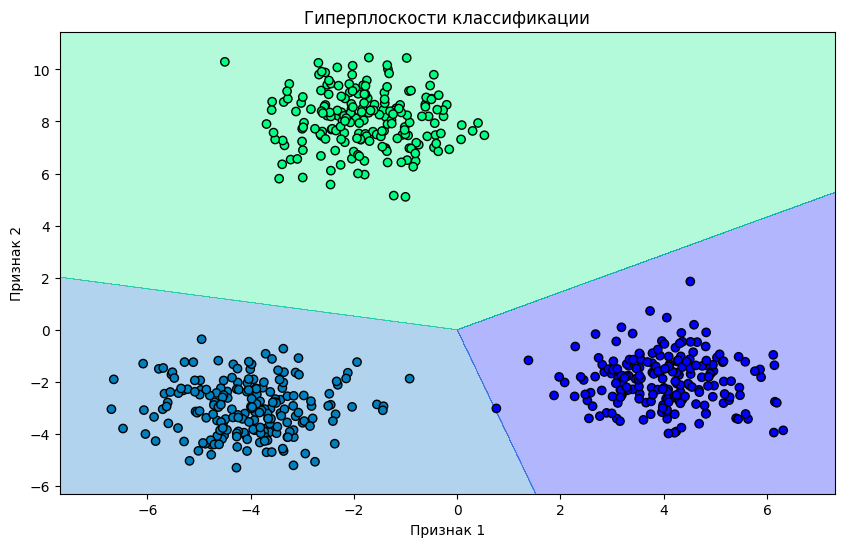

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 600
M = 3
d = 2
seed = 42
sigma1, sigma2, sigma3 = 1, 1, 1
mu1_1, mu1_2 = 4, -2   # центроида для первого класса
mu2_1, mu2_2 = -4, -3 # центроида для второго класса
mu3_1, mu3_2 = -2, 8   # центроида для третьего класса
np.random.seed(seed)

X1 = sigma1 * np.random.randn(int(N/M), d) + np.array([mu1_1, mu1_2])
y1 = np.array([1] * int(N/M))

X2 = sigma2 * np.random.randn(int(N/M), d) + np.array([mu2_1, mu2_2])
y2 = np.array([2] * int(N/M))

X3 = sigma3 * np.random.randn(int(N/M), d) + np.array([mu3_1, mu3_2])
y3 = np.array([3] * int(N/M))

X = np.vstack((X1, X2, X3))
Y = np.hstack((y1, y2, y3))

Y_one_hot = np.zeros((Y.size, M))
Y_one_hot[np.arange(Y.size), Y - 1] = 1

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def loss(X, Y, W):
    logits = X @ W.T
    probabilities = softmax(logits)
    return -np.sum(Y * np.log(probabilities + 1e-10))

def gradient(X, Y, W):
    logits = X @ W.T
    probabilities = softmax(logits)
    return X.T @ (Y - probabilities)

W = np.random.randn(M, X.shape[1])

learning_rate = 0.1
for epoch in range(1000):
    grad = gradient(X, Y_one_hot, W)
    W += learning_rate * grad.T

def plot_decision_boundary(W):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = softmax(np.c_[xx.ravel(), yy.ravel()] @ W.T)
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='winter')

plt.figure(figsize=(10, 6))
plot_decision_boundary(W)
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(Y_one_hot, axis=1), edgecolors='k', marker='o', cmap='winter')
plt.title('Гиперплоскости классификации')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.show()